In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
inspector = inspect(engine)

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

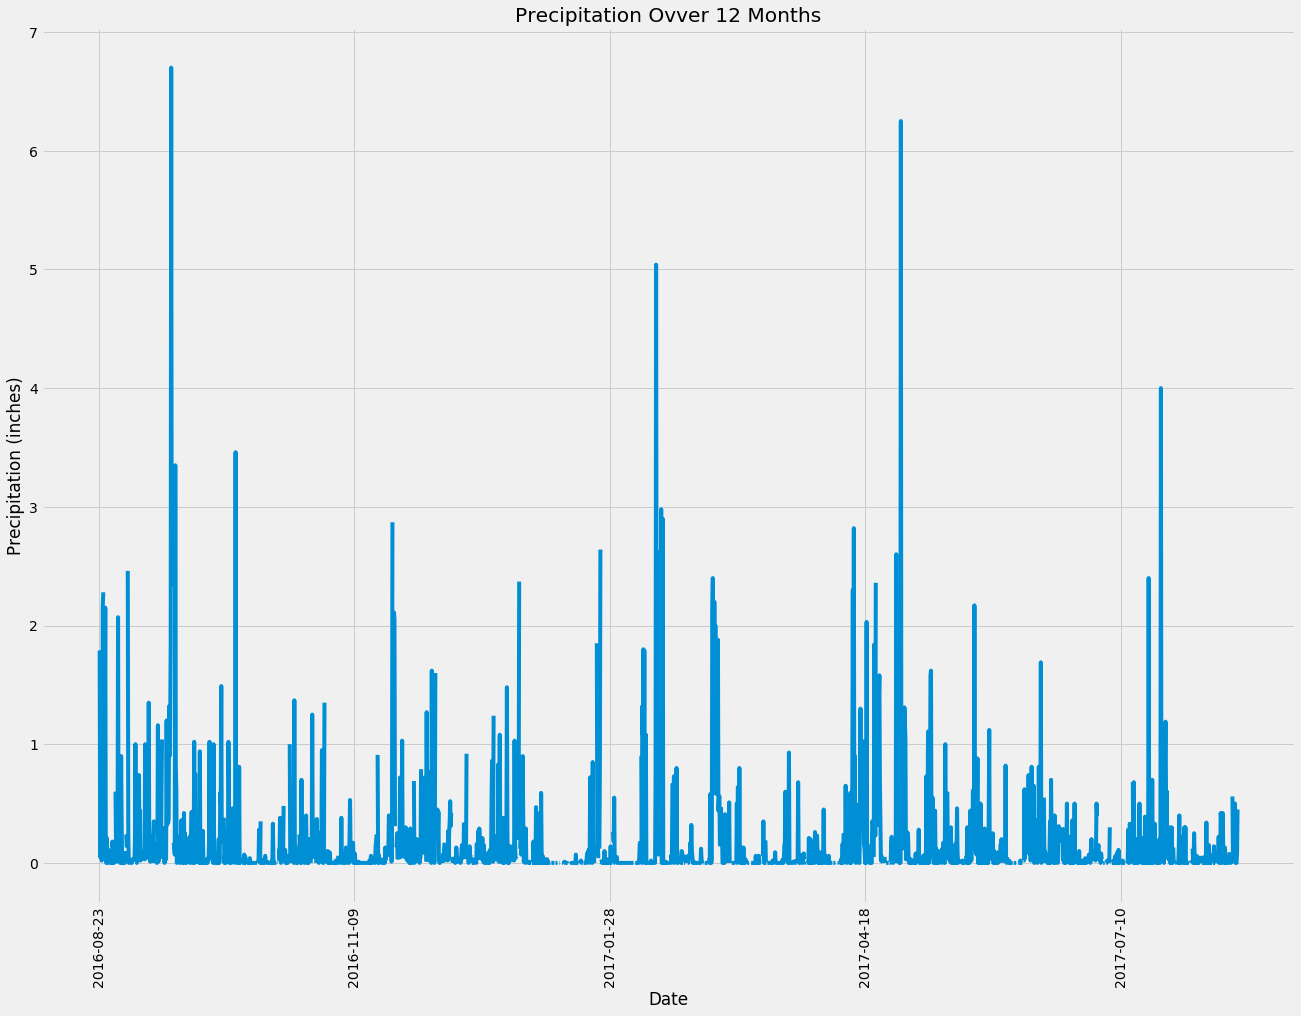

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_years_date = dt.date(2017, 8, 23) - dt.timedelta(365)
last_years_date

# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= last_years_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip_query, columns=['precipitation', 'date'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, figsize=(20,15), legend=False)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Ovver 12 Months')
plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x121f7f290>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f"There are {stations} stations in the data set.")

There are 9 stations in the data set.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
avg_act_station = active_station[0][0]
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == avg_act_station).all()
print(f"The lowest temperature recorded at station {avg_act_station} was {temps[0][0]}F")
print(f"The highest temperature recorded at station {avg_act_station} was {temps[0][1]}F")
print(f"The average temperature recorded at station {avg_act_station} was {round(temps[0][2],1)}F")

The lowest temperature recorded at station USC00519281 was 54.0F
The highest temperature recorded at station USC00519281 was 85.0F
The average temperature recorded at station USC00519281 was 71.7F


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observe = session.query(Measurement.tobs).\
    filter(Measurement.station == avg_act_station).\
    filter(Measurement.date >= precip_query).all()

observe_df = pd.DataFrame(obs, columns = ['temperature'])

observe_df.plot.hist(bins=12, title = f"Temp Observations at Station", figsize = (12, 10), ec = 'black', color = 'orange', legend = False)
plt.xlabel("Temperatures (Farenheight)")
plt.show()

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type.
[SQL: SELECT measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?]
[parameters: ('USC00519281', [(0.0, '2016-08-23'), (0.08, '2016-08-24'), (0.08, '2016-08-25'), (0.0, '2016-08-26'), (0.0, '2016-08-27'), (0.01, '2016-08-28'), (0.0, '2016-08-29'), ... (47769 characters truncated) ... .13, '2017-08-17'), (None, '2017-08-18'), (0.09, '2017-08-19'), (None, '2017-08-20'), (0.56, '2017-08-21'), (0.5, '2017-08-22'), (0.45, '2017-08-23')])]
(Background on this error at: http://sqlalche.me/e/rvf5)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
